In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, auc

from skopt import BayesSearchCV
from skopt.space import Real, Integer

import sys
sys.path.append('../src')
from gutatlas.models.xgboost import XGBBinClassTuner
from gutatlas.models.metrics import plot_shap_importance, plot_roc_curve, get_roc_auc, plot_confusion_matrix

import xgboost as xgb
from tensorflow import keras
import matplotlib.pyplot as plt
import shap
import os
import json
import re
import numpy as np
from pathlib import Path
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
gi_training = pd.read_parquet('../data/processed/gi_binary_training.parquet')
X = gi_training.drop(columns=['sample','disease_present'])
y = gi_training['disease_present']
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=42, stratify = y)

## XGBoost

In [ ]:
tuner = XGBBinClassTuner(cv_splits=5, n_iter=5, n_jobs=-1)
tuner.fit(X_train,y_train)
tuner.best_params(),tuner.best_score()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [5]:
tuner.save_model('../saved_models','gi_bin_class_xgboost_model.json')
tuner.save_params('../params','gi_bin_class_xgboost_params.json')

### confusion matrix

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/gutatlas/lib/python3.10/site-packages/matplotlib/pyplot.py'>

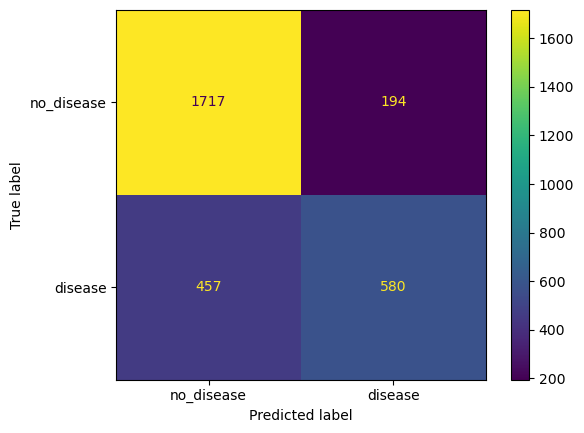

In [4]:
best_model = xgb.XGBClassifier()
best_model.load_model('../saved_models/gi_bin_class_xgboost_model.json')
preds = best_model.predict(X_test)
plot_confusion_matrix(y_test,preds)

### shap

/opt/anaconda3/envs/gutatlas/lib/python3.10/site-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


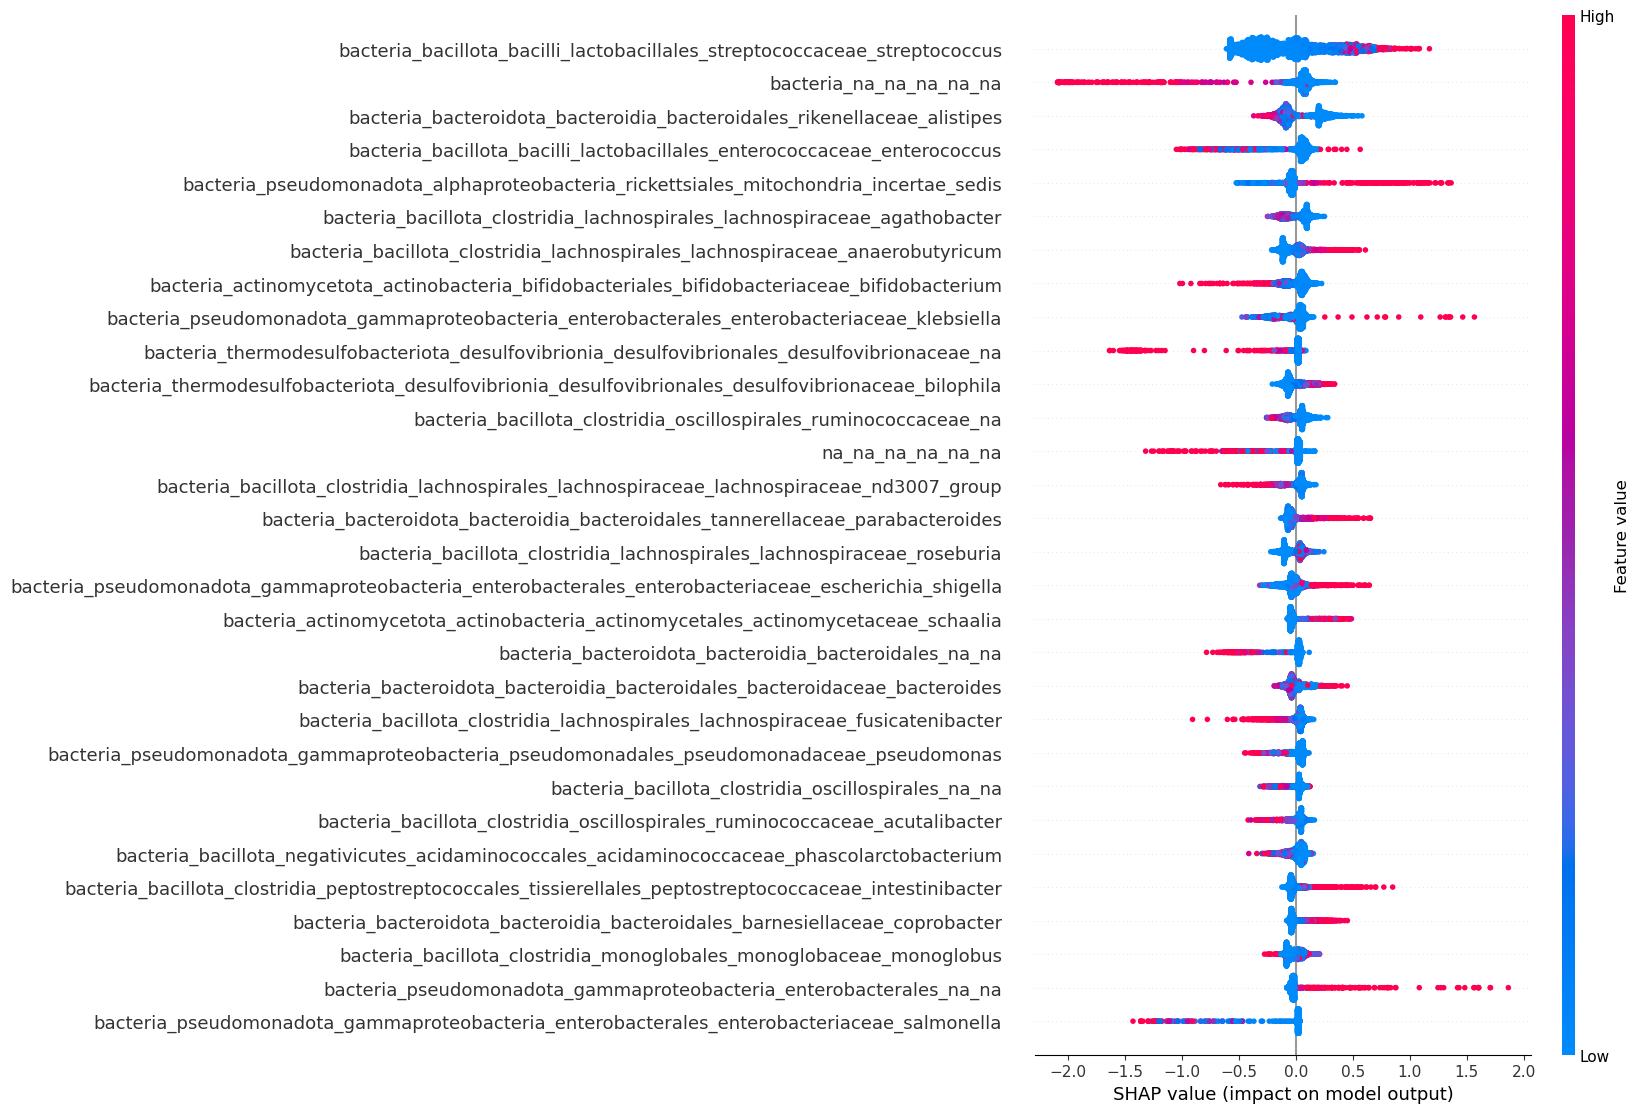

In [11]:
plot_shap_importance(best_model,X_test,max_display=30)

### roc auc

0.851459877772042


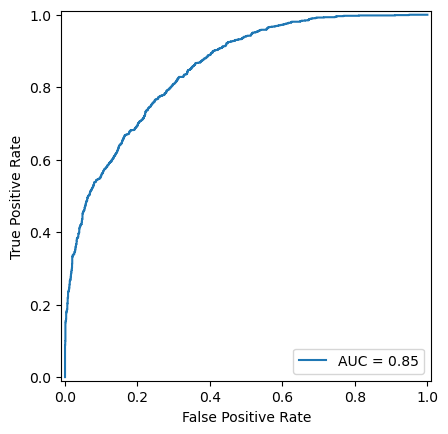

In [5]:
y_proba = best_model.predict_proba(X_test)
roc_auc = get_roc_auc(best_model,y_test,y_proba[:,1])
print(roc_auc)
plot_roc_curve(y_test,y_proba[:,1],roc_auc).show()

## logistic regression

0.7398177429862236


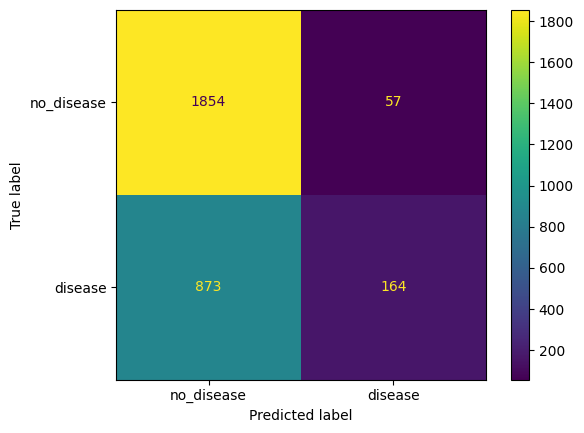

In [18]:
logist = LogisticRegression(penalty='l2')
logist.fit(X_train,y_train)
preds = logist.predict(X_test)
logist_roc_auc = roc_auc_score(y_test,logist.predict_proba(X_test)[:,1])
print(logist_roc_auc)
logist_cm = confusion_matrix(y_test,preds)
logist_cm_disp = ConfusionMatrixDisplay(logist_cm,display_labels=['no_disease','disease'])
logist_cm_disp.plot()
plt.show()

## neural net (sucks)

In [73]:
model = keras.Sequential([
    keras.layers.Input((X_train.shape[1],)),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer=keras.optimizers.Adam(learning_rate=0.001))

history = model.fit(X_train,y_train,epochs = 60, batch_size=1028,validation_split=0.1, verbose = 1)

Epoch 1/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5566 - loss: 0.6850 - val_accuracy: 0.6316 - val_loss: 0.6620
Epoch 2/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6525 - loss: 0.6502 - val_accuracy: 0.6316 - val_loss: 0.6489
Epoch 3/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6505 - loss: 0.6364 - val_accuracy: 0.6316 - val_loss: 0.6430
Epoch 4/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6554 - loss: 0.6247 - val_accuracy: 0.6441 - val_loss: 0.6286
Epoch 5/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6709 - loss: 0.6125 - val_accuracy: 0.6576 - val_loss: 0.6134
Epoch 6/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6784 - loss: 0.5984 - val_accuracy: 0.6644 - val_loss: 0.5961
Epoch 7/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6800 - loss: 0.5865 - val_accuracy: 0.6847 - val_loss: 0.5779
Epoch 8/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6939 - loss: 0.5708 - val_accuracy: 0.6994 - val_loss: 0.5626


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
0.7679601474890082


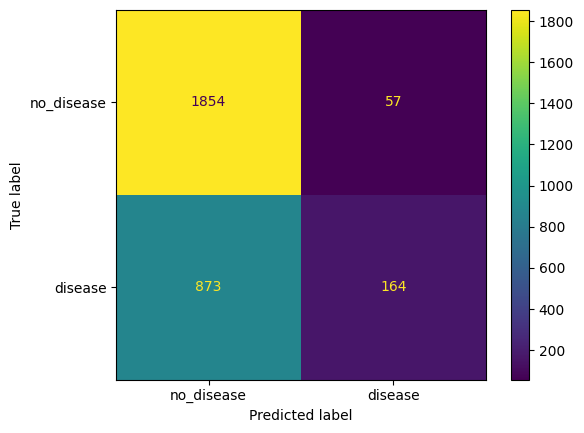

In [79]:
preds = model.predict(X_test)
nn_roc_auc = roc_auc_score(y_test,preds)
print(nn_roc_auc)

nn_cm = confusion_matrix(y_test,(preds > 0.5).astype(int)
)
nn_cm_disp = ConfusionMatrixDisplay(logist_cm,display_labels=['no_disease','disease'])
nn_cm_disp.plot()
plt.show()